# MLP classifier

In [1]:
# Libraries
from fastai.text import *

In [2]:
# Settings
path = 'data/Amazon_zip' #path to data files
bs = 48                  #batchsize (this should be set according to gpu capacity)

In [3]:
# Random seed
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [4]:
# Load vocabulary from language model task
random_seed(42, True)
data_lm = load_data(path, 'Amazon_lm_final.pkl', bs=bs)

In [ ]:
# Import data for classification (uncomment to run). 
# If the data has already been saved in your local machine, skip this cell and run the rest

#data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
#             #grab all the text files in path
#             .split_by_folder(valid='test')
#             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
#             .label_from_folder()
#             #label them all with their folders
#             .databunch(bs=bs, num_workers=0))

In [5]:
# Load data for classification task
random_seed(42, True)
data_clas = load_data(path, 'AZ_data_clas_final.pkl')



In [6]:
# Check shape
x,y = data_clas.one_batch()
x.shape,y.shape

(torch.Size([64, 926]), torch.Size([64]))

## MLP architecture, loss function and metrics

In [7]:
# Length vocabulary
n_v = len(data_lm.vocab.itos); n_v

# Define number of neurons for input and hidden layer 
n_h = 64

# Define number of neuron output layer (this is equivalent to the number of classes)
n_o = 2

In [8]:
# Define loss functions
def loss4(input,target): return F.cross_entropy(input, target[:,-1])

# Define performance metric
def acc4 (input,target): return accuracy(input, target[:,-1])

In [9]:
# Define MLP architecture
class Model_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(n_v,n_h) 
        self.h_h = nn.Linear(n_h,n_h, bias = True)    
        self.h_o = nn.Linear(n_h,n_o, bias = True)  
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], n_h).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return F.softmax(self.h_o(h))

In [10]:
random_seed(42, True)
learn = Learner(data_clas, Model_MLP(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


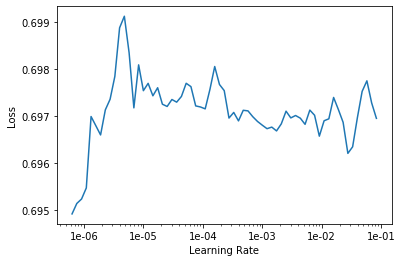

In [11]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot()

In [12]:
random_seed(42, True)

# Training
learn.fit_one_cycle(15, 2e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.697666,0.695578,0.500000,00:02
1,0.697060,0.694291,0.500000,00:02
2,0.696264,0.692727,0.525000,00:02
3,0.695277,0.692206,0.521875,00:02
4,0.694293,0.691344,0.559375,00:02
5,0.693175,0.691291,0.540625,00:02
6,0.692105,0.690766,0.546875,00:02
7,0.691028,0.690231,0.540625,00:02
8,0.689843,0.689897,0.537500,00:02
9,0.688787,0.689019,0.556250,00:02


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
#fin